In [1]:
%pip install numpy pandas tqdm lightgbm seaborn matplotlib plotnine scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# Preprocessing, modelling and evaluating
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
import hashlib
import os
import gc

In [3]:
train_transaction = pd.read_csv('train_transaction.csv', index_col='TransactionID')
train_identity = pd.read_csv('train_identity.csv', index_col='TransactionID')
train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
del train_transaction, train_identity
gc.collect()

0

In [4]:
test_transaction = pd.read_csv('test_transaction.csv', index_col='TransactionID')
test_identity = pd.read_csv('test_identity.csv', index_col='TransactionID')
test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)
del test_transaction, test_identity
gc.collect()

0

In [5]:
test.columns = test.columns.str.replace('-', '_')

In [6]:
selected_features = ['TransactionDT',
 'TransactionAmt','card1','card2','card3','card5',
 'addr1','addr2',
 'C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14',
 'D1','D2','D3','D4','D5','D6','D7','D8','D9','D10','D11','D12','D13','D14','D15','V307',
 'ProductCD',
 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9',
 'card4',
 'card6',
 'P_emaildomain',
 'R_emaildomain', 
 'dist1','id_30','id_31', 'id_32', 'id_33', 'id_34',
 'DeviceType','DeviceInfo',
  'V314', 'V310', 'V127', 'V78', 'V62'
 ]

len(selected_features)

65

In [7]:
train.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [8]:
train = train[selected_features + ['isFraud']]
test = test[selected_features ]

In [9]:
train = train.fillna(-999)
test = test.fillna(-999)

In [10]:
# 점수비교 
# https://www.kaggle.com/kyakovlev/ieee-gb-2-make-amount-useful-again

train['uid'] = train['card1'].astype(str)+'_'+train['card2'].astype(str)+'_'+train['card3'].astype(str)+'_'+train['card4'].astype(str)
test['uid'] = test['card1'].astype(str)+'_'+test['card2'].astype(str)+'_'+test['card3'].astype(str)+'_'+test['card4'].astype(str)

train['uid2'] = train['uid'].astype(str)+'_'+train['addr1'].astype(str)+'_'+train['addr2'].astype(str)
test['uid2'] = test['uid'].astype(str)+'_'+test['addr1'].astype(str)+'_'+test['addr2'].astype(str)

i_cols = ['card1','card2','card3','card5','uid','uid2']

for col in i_cols:
    for agg_type in ['mean', 'std', 'nunique']:
        new_col_name = col+'_TransactionAmt_'+agg_type
        temp = pd.concat([train[[col, 'TransactionAmt']], test[[col,'TransactionAmt']]])
        temp = temp.groupby([col])['TransactionAmt'].agg([agg_type]).reset_index().rename(
                                                columns={agg_type: new_col_name})
        
        temp.index = list(temp[col])
        temp = temp[new_col_name].to_dict()   
        
        train[new_col_name] = train[col].map(temp)
        test[new_col_name]  = test[col].map(temp)
        
########################### Anomaly Search in geo information

# Let's look on bank addres and client addres matching
# card3/card5 bank country and name?
# Addr2 -> Clients geo position (country)
# Most common entries -> normal transactions
# Less common etries -> some anonaly
train['bank_type'] = train['card3'].astype(str)+'_'+train['card5'].astype(str)
test['bank_type']  = test['card3'].astype(str)+'_'+test['card5'].astype(str)

train['address_match'] = train['bank_type'].astype(str)+'_'+train['addr2'].astype(str)
test['address_match']  = test['bank_type'].astype(str)+'_'+test['addr2'].astype(str)

for col in ['address_match','bank_type']:
    temp = pd.concat([train[[col]], test[[col]]])
    temp[col] = np.where(temp[col].str.contains('nan'), np.nan, temp[col])
    temp = temp.dropna()
    fq_encode = temp[col].value_counts().to_dict()   
    train[col] = train[col].map(fq_encode)
    test[col]  = test[col].map(fq_encode)

train['address_match'] = train['address_match']/train['bank_type'] 
test['address_match']  = test['address_match']/test['bank_type']

Date

In [11]:
import datetime
# timeblock으로 시간을 만드는 코드 

start_date = datetime.datetime.strptime('2017.11.30', '%Y.%m.%d')
train['timeblock'] = train['TransactionDT'].apply(lambda x: datetime.timedelta(seconds=x) + start_date)
test['timeblock'] = test['TransactionDT'].apply(lambda x: datetime.timedelta(seconds=x) + start_date)

tb = train['timeblock']
train.drop('timeblock', axis=1, inplace=True)
train.insert(0, 'timeblock', tb)

tb = test['timeblock']
test.drop('timeblock', axis=1, inplace=True)
test.insert(0, 'timeblock', tb)

# "가입일로부터의 시간"(D8)을 통해 "가입일"을 만드는 코드. 
def account_start_date(val):
    if np.isnan(val):
        return np.NaN
    else:
        days = int(str(val).split('.')[0])
        return pd.Timedelta(str(days) + ' days')

for i in ['D1', 'D2', 'D4', 'D8', 'D10', 'D15']:
    train['account_start_day'] = train[i].apply(account_start_date)
    test['account_start_day'] = test[i].apply(account_start_date)

    # account_make_date 컴퓨터가 인식할 수 있도록 수치형으로 바꿔 줌. 
    train['account_make_date'] = (train['timeblock'] - train['account_start_day']).dt.date
    test['account_make_date'] = (test['timeblock'] - test['account_start_day']).dt.date

    train['account_make_date_{}'.format(i)] = (10000 * pd.to_datetime(train['account_make_date']).dt.year) + (100 * pd.to_datetime(train['account_make_date']).dt.month) + (1 * pd.to_datetime(train['account_make_date']).dt.day)
    test['account_make_date_{}'.format(i)] = (10000 * pd.to_datetime(test['account_make_date']).dt.year) + (100 * pd.to_datetime(test['account_make_date']).dt.month) + (1 * pd.to_datetime(test['account_make_date']).dt.day)

del train['account_make_date']; del test['account_make_date']
del train['account_start_day']; del test['account_start_day']
train['date'] = pd.to_datetime(train['timeblock']).dt.date
test['date'] = pd.to_datetime(test['timeblock']).dt.date

train['year'] = train['timeblock'].dt.year
train['month'] = train['timeblock'].dt.month
train['day'] = train['timeblock'].dt.day
train['dayofweek'] = train['timeblock'].dt.dayofweek
train['hour'] = train['timeblock'].dt.hour
# train['minute'] = train['timeblock'].dt.minute
# train['second'] = train['timeblock'].dt.second

test['year'] = test['timeblock'].dt.year
test['month'] = test['timeblock'].dt.month
test['day'] = test['timeblock'].dt.day
test['dayofweek'] = test['timeblock'].dt.dayofweek
test['hour'] = test['timeblock'].dt.hour
# test['minute'] = test['timeblock'].dt.minute
# test['second'] = test['timeblock'].dt.second


In [12]:

def card_info_hash(x):
    s = (str(int(x['card1']))+
         str(int(x['card2']))+
         str(int(x['card3']))+
         str(x['card4'])+
         str(int(x['card5']))+
         str(x['card6']))
    h = hashlib.sha256(s.encode('utf-8')).hexdigest()[0:15]
    return h

def device_hash(x):
    s =  str(x['id_30'])+str(x['id_31'])+str(x['id_32'])+str(x['id_33'])+str( x['DeviceType'])+ str(x['DeviceInfo'])
    h = hashlib.sha256(s.encode('utf-8')).hexdigest()[0:15]
    return h

train['card_hash'] = train.apply(lambda x: card_info_hash(x), axis=1)
train['device_hash'] = train.apply(lambda x: device_hash(x), axis=1)

test['card_hash'] = test.apply(lambda x: card_info_hash(x), axis=1)
test['device_hash'] = test.apply(lambda x: device_hash(x), axis=1)

##### Card_device 조합에서 V307 적용

In [13]:
train['V307_diff'] = train['V307'].diff().shift(-1)
train['difference'] = train['V307_diff'] - train['TransactionAmt']

test['v307_diff'] = test['V307'].diff().shift(-1)
test['difference'] = test['v307_diff'] - test['TransactionAmt']

prev / next click


In [14]:
# train['uid2_prev_click'] = train['TransactionDT'] - train.groupby(['uid2'])['TransactionDT'].shift(1)
# test['uid2_prev_click'] = test['TransactionDT'] - test.groupby(['uid2'])['TransactionDT'].shift(1)
total = pd.concat([train,test],axis=0,sort=False)

train['uid2_next_click'] = train['TransactionDT'] - train.groupby(['uid2'])['TransactionDT'].shift(-1)
test['uid2_next_click'] = test['TransactionDT'] - test.groupby(['uid2'])['TransactionDT'].shift(-1)
# del train['uid']; del train['uid2']; del train['bank_type']
# del test['uid']; del test['uid2']; del test['bank_type']
train = train.merge(total.groupby(['card1','account_make_date_D1','ProductCD'])['TransactionAmt'].agg({'mean','std'}).reset_index().rename(columns={'mean':'card1_D1_productCD_Amt_mean','std':'card1_D1_productCD_Amt_std'}), how='left', on = ['card1','account_make_date_D1','ProductCD'])
test = test.merge(total.groupby(['card1','account_make_date_D1','ProductCD'])['TransactionAmt'].agg({'mean','std'}).reset_index().rename(columns={'mean':'card1_D1_productCD_Amt_mean','std':'card1_D1_productCD_Amt_std'}), how='left', on = ['card1','account_make_date_D1','ProductCD'])
train = train.merge(total.groupby(['card1','card2','card3','card4','addr1','addr2','ProductCD'])['dayofweek'].agg({'mean','std'}).reset_index().rename(columns={'mean':'uid2_dayofweek_mean','std':'uid2_dayofweek_std'}), how='left', on = ['card1','card2','card3','card4','addr1','addr2','ProductCD'])
test = test.merge(total.groupby(['card1','card2','card3','card4','addr1','addr2','ProductCD'])['dayofweek'].agg({'mean','std'}).reset_index().rename(columns={'mean':'uid2_dayofweek_mean','std':'uid2_dayofweek_std'}), how='left', on = ['card1','card2','card3','card4','addr1','addr2','ProductCD'])

In [15]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_row', None)
train.head()

,timeblock,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V307,ProductCD,M1,M2,M3,M4,M5,M6,M7,M8,M9,card4,card6,P_emaildomain,R_emaildomain,dist1,id_30,id_31,id_32,id_33,id_34,DeviceType,DeviceInfo,V314,V310,V127,V78,V62,isFraud,uid,uid2,card1_TransactionAmt_mean,card1_TransactionAmt_std,card1_TransactionAmt_nunique,card2_TransactionAmt_mean,card2_TransactionAmt_std,card2_TransactionAmt_nunique,card3_TransactionAmt_mean,card3_TransactionAmt_std,card3_TransactionAmt_nunique,card5_TransactionAmt_mean,card5_TransactionAmt_std,card5_TransactionAmt_nunique,uid_TransactionAmt_mean,uid_TransactionAmt_std,uid_TransactionAmt_nunique,uid2_TransactionAmt_mean,uid2_TransactionAmt_std,uid2_TransactionAmt_nunique,bank_type,address_match,account_make_date_D1,account_make_date_D2,account_make_date_D4,account_make_date_D8,account_make_date_D10,account_make_date_D15,date,year,month,day,dayofweek,hour,card_hash,device_hash,V307_diff,difference,uid2_next_click,card1_D1_productCD_Amt_mean,card1_D1_productCD_Amt_std,uid2_dayofweek_mean,uid2_dayofweek_std
0,2017-12-01 00:00:00,86400,68.5,13926,-999.0,150.0,142.0,315.0,87.0,1,1,0,0,0,1,0,0,1,0,2,0,1,1,14.0,-999.0,13.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,13.0,13.0,-999.0,-999.0,-999.0,0.0,117.0,W,T,T,T,M2,F,T,-999,-999,-999,discover,credit,-999,-999,19.0,-999,-999,-999.0,-999,-999,-999,-999,0.0,0.0,117.0,1.0,1.0,0,13926_-999.0_150.0_discover,13926_-999.0_150.0_discover_315.0_87.0,316.570357,351.513997,33,143.732314,246.331972,2206,147.65346,255.330369,21143,185.236343,322.134467,123,257.916667,210.732868,5,193.000000,176.069589,2,309,1.000000,20171117,20200826,20200826,20200826,20171118,20171201,2017-12-01,2017,12,1,4,0,8ead5cb612554b9,4752958457aa9a9,-117.0,-185.5,-6286225.0,68.500000,NaN,5.000000,1.414214
1,2017-12-01 00:00:01,86401,29.0,2755,404.0,150.0,102.0,325.0,87.0,1,1,0,0,0,1,0,0,0,0,1,0,1,1,0.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,-999.0,0.0,0.0,W,-999,-999,-999,M0,T,T,-999,-999,-999,mastercard,credit,gmail.com,-999,-999.0,-999,-999,-999.0,-999,-999,-999,-999,0.0,0.0,0.0,1.0,1.0,0,2755_404.0_150.0_mastercard,2755_404.0_150.0_mastercard_325.0_87.0,213.053819,391.543884,335,227.107106,373.703941,888,147.65346,255.330369,21143,212.793700,396.390243,6804,213.629639,392.797197,334,239.981619,503.767457,53,44082,0.992128,20171201,20200826,20171201,20200826,20171201,20171201,2017-12-01,2017,12,1,4,0,8c1479ec0bda456,4752958457aa9a9,0.0,-29.0,-413142.0,29.000000,NaN,3.000000,1.776130
2,2017-12-01 00:01:09,86469,59.0,4663,490.0,150.0,166.0,330.0,87.0,1,1,0,0,0,1,0,0,1,0,1,0,1,1,0.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,315.0,-999.0,-999.0,-999.0,315.0,0.0,W,T,T,T,M0,F,F,F,F,F,visa,debit,outlook.com,-999,287.0,-999,-999,-999.0,-999,-999,-999,-999,0.0,0.0,0.0,1.0,1.0,0,4663_490.0_150.0_visa,4663_490.0_150.0_visa_330.0_87.0,104.876940,130.380968,284,136.179809,228.571548,2763,147.65346,255.330369,21143,98.774960,141.059909,3382,104.827829,130.363122,284,65.685652,55.170209,23,101292,0.998884,20171201,20200826,20171201,20200826,20171201,20170120,2017-12-01,2017,12,1,4,0,963f93abc860336,4752958457aa9a9,1758.0,1699.0,-864538.0,100.611633,77.010964,3.244444,1.568954
3,2017-12-01 00:01:39,86499,50.0,18132,567.0,150.0,117.0,476.0,87.0,2,5,0,0,0,4,0,0,1,0,1,0,25,1,112.0,112.0,0.0,94.0,0.0,-999.0,-999.0,-999.0,-999.0,84.0,-999.0,-999.0,-999.0,-999.0,111.0,1758.0,W,-999,-999,-999,M0,T,F,-999,-999,-999,mastercard,debit,yahoo.com,-999,-999.0,-999,-999,-999.0,-999,-999,-999,-999,0.0,354.0,1758.0,1.0,1.0,0,18132_567.0_150.0_mastercard,18132_567.0_150.0_mastercard_476.0_87.0,120.958705,196.463487,580,133.628801,226.771834,774,147.65346,255.330369,21143,124.389514,191.880900,1776,120.967279,196.723219,578,113.086685,211.762109,109,47059,0.997684,20170811,20170811,20170829,20200826,20170908,20170812,2017-12-01,2017,12,1,4,0,7f85e7defc9a181,4

In [16]:

def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object and not np.issubdtype(col_type, np.datetime64):
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

# 적용
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Memory usage of dataframe is 470.82 MB
Memory usage after optimization is: 223.02 MB
Decreased by 52.6%
Memory usage of dataframe is 400.10 MB
Memory usage after optimization is: 192.32 MB
Decreased by 51.9%


In [18]:
# test = test.drop(['V307','id_30','id_31','id_32','id_33','DeviceType','DeviceInfo'], axis=1)
# train = train.drop(['V307','id_30','id_31','id_32','id_33','DeviceType','DeviceInfo'], axis=1)

Extract target variable¶


In [17]:
from sklearn.preprocessing import LabelEncoder

# 범주형 열을 숫자형으로 변환
def encode_categorical_columns(df):
    label_encoders = {}
    for column in df.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column].astype(str))
        label_encoders[column] = le
    return df, label_encoders

# train 데이터 인코딩
train, _ = encode_categorical_columns(train)

# test 데이터 인코딩
test_encoded, _ = encode_categorical_columns(test)

In [18]:
train_columns = train.shape[1]
test_columns = test_encoded.shape[1]

print("Number of columns in train:", train_columns)
print("Number of columns in test_encoded:", test_columns)

Number of columns in train: 110
Number of columns in test_encoded: 109


In [19]:
y = train['isFraud']
X = train.drop('isFraud', axis=1)

In [20]:
train.head()

c:\Users\USER\Desktop\광인사\1_Project\.venv\Lib\site-packages\pandas\io\formats\format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,timeblock,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V307,ProductCD,M1,M2,M3,M4,M5,M6,M7,M8,M9,card4,card6,P_emaildomain,R_emaildomain,dist1,id_30,id_31,id_32,id_33,id_34,DeviceType,DeviceInfo,V314,V310,V127,V78,V62,isFraud,uid,uid2,card1_TransactionAmt_mean,card1_TransactionAmt_std,card1_TransactionAmt_nunique,card2_TransactionAmt_mean,card2_TransactionAmt_std,card2_TransactionAmt_nunique,card3_TransactionAmt_mean,card3_TransactionAmt_std,card3_TransactionAmt_nunique,card5_TransactionAmt_mean,card5_TransactionAmt_std,card5_TransactionAmt_nunique,uid_TransactionAmt_mean,uid_TransactionAmt_std,uid_TransactionAmt_nunique,uid2_TransactionAmt_mean,uid2_TransactionAmt_std,uid2_TransactionAmt_nunique,bank_type,address_match,account_make_date_D1,account_make_date_D2,account_make_date_D4,account_make_date_D8,account_make_date_D10,account_make_date_D15,date,year,month,day,dayofweek,hour,card_hash,device_hash,V307_diff,difference,uid2_next_click,card1_D1_productCD_Amt_mean,card1_D1_productCD_Amt_std,uid2_dayofweek_mean,uid2_dayofweek_std
0,2017-12-01 00:00:00,86400,68.5,13926,-999.0,150.0,142.0,315.0,87.0,1,1,0,0,0,1,0,0,1,0,2,0,1,1,14.0,-999.0,13.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,13.0,13.0,-999.0,-999.0,-999.0,0.0,117.0,4,2,2,2,3,1,2,0,0,0,2,2,0,0,19.0,0,0,-999.0,0,0,0,0,0.0,0.0,117.0,1.0,1.0,0,3658,10322,316.5000,351.5000,33,143.750,246.375,2206,147.625,255.375,21143,185.250,322.250,123,258.0000,210.7500,5,193.0000,176.12500,2,309,1.000000,20171117,20200826,20200826,20200826,20171118,20171201,0,2017,12,1,4,0,8296,2763,-117.0,-185.5,-6286225.0,68.500,NaN,5.000000,1.414062
1,2017-12-01 00:00:01,86401,29.0,2755,404.0,150.0,102.0,325.0,87.0,1,1,0,0,0,1,0,0,0,0,1,0,1,1,0.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,-999.0,0.0,0.0,4,0,0,0,1,2,2,0,0,0,3,2,17,0,-999.0,0,0,-999.0,0,0,0,0,0.0,0.0,0.0,1.0,1.0,0,8497,24212,213.0000,391.5000,335,227.125,373.750,888,147.625,255.375,21143,212.750,396.500,6804,213.6250,392.7500,334,240.0000,503.75000,53,44082,0.992188,20171201,20200826,20171201,20200826,20171201,20171201,0,2017,12,1,4,0,8152,2763,0.0,-29.0,-413142.0,29.000,NaN,3.000000,1.776367
2,2017-12-01 00:01:09,86469,59.0,4663,490.0,150.0,166.0,330.0,87.0,1,1,0,0,0,1,0,0,1,0,1,0,1,1,0.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,315.0,-999.0,-999.0,-999.0,315.0,0.0,4,2,2,2,1,1,1,1,1,1,4,3,36,0,287.0,0,0,-999.0,0,0,0,0,0.0,0.0,0.0,1.0,1.0,0,10070,28509,104.8750,130.3750,284,136.125,228.625,2763,147.625,255.375,21143,98.750,141.000,3382,104.8125,130.3750,284,65.6875,55.15625,23,101292,0.999023,20171201,20200826,20171201,20200826,20171201,20170120,0,2017,12,1,4,0,8694,2763,1758.0,1699.0,-864538.0,100.625,77.000,3.244141,1.569336
3,2017-12-01 00:01:39,86499,50.0,18132,567.0,150.0,117.0,476.0,87.0,2,5,0,0,0,4,0,0,1,0,1,0,25,1,112.0,112.0,0.0,94.0,0.0,-999.0,-999.0,-999.0,-999.0,84.0,-999.0,-999.0,-999.0,-999.0,111.0,1758.0,4,0,0,0,1,2,1,0,0,0,3,3,54,0,-999.0,0,0,-999.0,0,0,0,0,0.0,354.0,1758.0,1.0,1.0,0,7494,21088,120.9375,196.5000,580,133.625,226.750,774,147.625,255.375,21143,124.375,191.875,1776,120.9375,196.7500,578,113.0625,211.75000,109,47059,0.997559,20170811,20170811,20170829,20200826,20170908,20170812,0,2017,12,1,4,0,7408,2763,-1758.0,-1808.0,-8498.0,67.000,41.125,3.013672,1.973633
4,2017-12-01 00:01:46,86506,50.0,4497,514.0,150.0,102.0,420.0,87.0,1,1,0,0,0,1,0,1,0,1,1,0,1,1,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,1,0,0,0,0,0,0,0,0,0,3,2,17,0,-999.0,8,124,32.0,165,4,2,955,0.0,0.0,0.0,-999.0,-999.0,0,9944,28156,99.8125,69.8125,18,223.750,458.000,2311,147.625,255.375,21143,212.750,396.500,6804,99.8125,69.8125,18,50.0000,NaN,1,44082,0.992188,20171201,20200826,20200826,20200826,20200826,20200826,0,2017,12,1,4,0,12607,7016,0.0,-50.0,NaN,50.000,NaN,4.000000,NaN


In [ ]:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# import lightgbm as lgb

# # Convert DateTime columns to numerical format
# def convert_datetime_columns(df):
#     for col in df.columns:
#         if pd.api.types.is_datetime64_any_dtype(df[col]):
#             df[col] = df[col].astype('int64') // 10**9  # Convert to seconds since epoch
#     return df

# # Assuming X is your feature DataFrame
# X = convert_datetime_columns(X)

# # train, valid split
# X_tr, X_v, y_tr, y_v = train_test_split(X, y, test_size=0.25, random_state=2024, stratify=y)

# # 데이터 셋 생성
# train_data = lgb.Dataset(X_tr, label=y_tr)
# valid_data = lgb.Dataset(X_v, label=y_v)

# params = {
#     'objective': 'binary',
#     'metric': 'auc'
# }

# # 모델 학습
# callbacks = [lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(period=100)]
# clf = lgb.train(params, train_data, num_boost_round=10000, valid_sets=[train_data, valid_data], callbacks=callbacks)

[LightGBM] [Info] Number of positive: 15497, number of negative: 427408
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.249745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17769
[LightGBM] [Info] Number of data points in the train set: 442905, number of used features: 102
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.034989 -> initscore=-3.317093
[LightGBM] [Info] Start training from score -3.317093
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.955249	valid_1's auc: 0.941387
[200]	training's auc: 0.973913	valid_1's auc: 0.955242
[300]	training's auc: 0.983095	valid_1's auc: 0.961672
[400]	training's auc: 0.988651	valid_1's auc: 0.965172
[500]	training's auc: 0.992577	valid_1's auc: 0.967918
[600]	training's auc: 0.995238	valid_1's auc: 0.969742
[700]	training's auc: 0.996822	valid_1's auc: 0.971101
[800]	training's auc: 0.997942	valid_1's auc: 0.971954


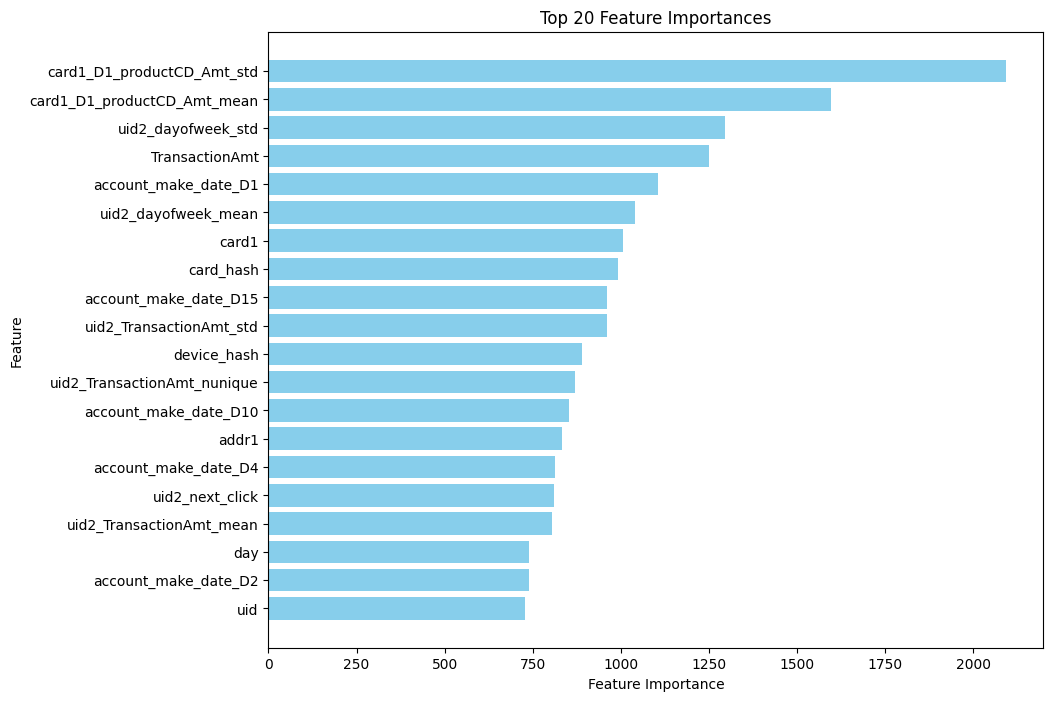

In [ ]:
# import matplotlib.pyplot as plt

# # 피처 중요도 추출
# importance = clf.feature_importance()
# feature_names = X_tr.columns

# # 피처 중요도를 데이터프레임으로 변환
# importance_df = pd.DataFrame({
#     'feature': feature_names,
#     'importance': importance
# })

# # 중요도 순으로 정렬하고 상위 20개 피처 선택
# top_20_features = importance_df.sort_values(by='importance', ascending=False).head(20)

# # 피처 중요도 시각화
# plt.figure(figsize=(10, 8))
# plt.barh(top_20_features['feature'], top_20_features['importance'], color='skyblue')
# plt.xlabel('Feature Importance')
# plt.ylabel('Feature')
# plt.title('Top 20 Feature Importances')
# plt.gca().invert_yaxis()  # 가장 중요한 피처가 위에 오도록 y축을 반전
# plt.show()

In [ ]:

# import pandas as pd
# import numpy as np

# # DateTime64 타입의 열을 숫자 형식으로 변환하는 함수
# def convert_datetime_columns(df):
#     for col in df.columns:
#         if pd.api.types.is_datetime64_any_dtype(df[col]):
#             df[col] = df[col].astype('int64') // 10**9  # 초 단위로 변환
#     return df

# # test_encoded 데이터프레임의 DateTime64 타입 열 변환
# test_encoded = convert_datetime_columns(test_encoded)

# # 예측 수행
# preds = clf.predict(test_encoded)

# # 결과 저장
# result = pd.read_csv("sample_submission.csv")
# result['isFraud'] = preds
# result.to_csv('result.csv', index=False)

In [ ]:
# def print_columns(df):
#     print("Columns in the DataFrame:")
#     print(", ".join(df.columns))

# print_columns(test_encoded)
# print_columns(train)

Columns in the DataFrame:
timeblock, TransactionDT, TransactionAmt, card1, card2, card3, card5, addr1, addr2, C1, C2, C3, C4, C5, C6, C7, C8, C9, C10, C11, C12, C13, C14, D1, D2, D3, D4, D5, D6, D7, D8, D9, D10, D11, D12, D13, D14, D15, ProductCD, M1, M2, M3, M4, M5, M6, M7, M8, M9, card4, card6, P_emaildomain, R_emaildomain, dist1, id_34, V314, V310, V127, V78, V62, uid, uid2, card1_TransactionAmt_mean, card1_TransactionAmt_std, card1_TransactionAmt_nunique, card2_TransactionAmt_mean, card2_TransactionAmt_std, card2_TransactionAmt_nunique, card3_TransactionAmt_mean, card3_TransactionAmt_std, card3_TransactionAmt_nunique, card5_TransactionAmt_mean, card5_TransactionAmt_std, card5_TransactionAmt_nunique, uid_TransactionAmt_mean, uid_TransactionAmt_std, uid_TransactionAmt_nunique, uid2_TransactionAmt_mean, uid2_TransactionAmt_std, uid2_TransactionAmt_nunique, bank_type, address_match, account_make_date_D1, account_make_date_D2, account_make_date_D4, account_make_date_D8, account_make_dat

#### 각 C 컬럼별로 'TransactionAmt'의 평균과 총합 계산
- 평균 
1. C 피처는 거래와 관련된 다양한 계산된 값들 나타내며, 각 C 피처별로 TransactionAmt의 평균을 계산하여 각 그룹의 평균 거래 금액을 구함
2. C1~C14의 평균 거래 금액이 높거나 낮은 것은 해당 그룹이 정상 트랜잭션인지, 이상 트랜잭션인지에 대한 단서를 제공   
- 합 
1. C 피처별로 TransactionAmt의 총합을 계산하여 각 그룹의 총 거래 금액을 구합니다
2. C1~C14 의 총 거래 금액이 비정상적으로 높거나 낮은 것은 해당 그룹이 사기 트랜잭션일 가능성을 시사

In [23]:
# 각 C 컬럼별로 'TransactionAmt'의 평균과 총합 계산 함수
def calculate_transaction_amt_stats(df):
    # TransactionAmt를 float64로 변환
    df['TransactionAmt'] = df['TransactionAmt'].astype('float64')
    for col in [f'C{i}' for i in range(1, 15)]:
        # 각 C 컬럼을 float64로 변환
        df[col] = df[col].astype('float64')
        df[f'{col}_TransactionAmt_mean'] = df.groupby(col)['TransactionAmt'].transform('mean')
        df[f'{col}_TransactionAmt_sum'] = df.groupby(col)['TransactionAmt'].transform('sum')
    return df

# train 데이터프레임에 적용
train = calculate_transaction_amt_stats(train)

# test 데이터프레임에 적용
test = calculate_transaction_amt_stats(test)

C:\Users\USER\AppData\Local\Temp\ipykernel_18168\1360928571.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_TransactionAmt_mean'] = df.groupby(col)['TransactionAmt'].transform('mean')
C:\Users\USER\AppData\Local\Temp\ipykernel_18168\1360928571.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_TransactionAmt_sum'] = df.groupby(col)['TransactionAmt'].transform('sum')
C:\Users\USER\AppData\Local\Temp\ipykernel_18168\1360928571.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the

In [21]:
train.head()
test.head()
# test 데이터프레임의 v307_diff 열 이름을 V307_diff로 변경
test.rename(columns={'v307_diff': 'V307_diff'}, inplace=True)

In [ ]:
# Private : 0.8800
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import lightgbm as lgb

# Convert DateTime columns to numerical format
def convert_datetime_columns(df):
    for col in df.columns:
        if pd.api.types.is_datetime64_any_dtype(df[col]):
            df[col] = df[col].astype('int64') // 10**9  # Convert to seconds since epoch
    return df

# 원하는 피처 선택
selected_features = [
    'TransactionDT', 'TransactionAmt', 'card1', 'card2', 'card3', 'card5',
    'addr1', 'addr2', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9',
    'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6',
    'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'ProductCD',
    'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'dist1', 'id_34',
    'V314', 'V310', 'V127', 'V78', 'V62', 'card_hash', 'device_hash',
    'difference','V307_diff','uid', 'uid2',
    'C1_TransactionAmt_mean', 'C1_TransactionAmt_sum',
    'C2_TransactionAmt_mean', 'C2_TransactionAmt_sum',
    'C3_TransactionAmt_mean', 'C3_TransactionAmt_sum',
    'C4_TransactionAmt_mean', 'C4_TransactionAmt_sum',
    'C5_TransactionAmt_mean', 'C5_TransactionAmt_sum',
    'C6_TransactionAmt_mean', 'C6_TransactionAmt_sum',
    'C7_TransactionAmt_mean', 'C7_TransactionAmt_sum',
    'C8_TransactionAmt_mean', 'C8_TransactionAmt_sum',
    'C9_TransactionAmt_mean', 'C9_TransactionAmt_sum',
    'C10_TransactionAmt_mean', 'C10_TransactionAmt_sum',
    'C11_TransactionAmt_mean', 'C11_TransactionAmt_sum',
    'C12_TransactionAmt_mean', 'C12_TransactionAmt_sum',
    'C13_TransactionAmt_mean', 'C13_TransactionAmt_sum',
    'C14_TransactionAmt_mean', 'C14_TransactionAmt_sum',
    "card1_TransactionAmt_mean","card1_TransactionAmt_std","card1_TransactionAmt_nunique",
    "card2_TransactionAmt_mean","card2_TransactionAmt_std","card2_TransactionAmt_nunique",
    "card3_TransactionAmt_mean","card3_TransactionAmt_std","card3_TransactionAmt_nunique",
    "card5_TransactionAmt_mean","card5_TransactionAmt_std","card5_TransactionAmt_nunique",
    "uid_TransactionAmt_mean","uid_TransactionAmt_std","uid_TransactionAmt_nunique",
    "uid2_TransactionAmt_mean","uid2_TransactionAmt_std","uid2_TransactionAmt_nunique",
    "bank_type","address_match","account_make_date_D1","account_make_date_D2","account_make_date_D4",
    "account_make_date_D8","account_make_date_D10","account_make_date_D15",
    "date","year","month","day","dayofweek","hour", "uid2_next_click",
    "card1_D1_productCD_Amt_mean","card1_D1_productCD_Amt_std","uid2_dayofweek_mean",
    "uid2_dayofweek_std"
]

# Assuming that train and test have all required features including 'isFraud' for train
X = train[selected_features]
y = train['isFraud']
X_test = test[selected_features]

# DateTime 컬럼 변환
X = convert_datetime_columns(X)
X_test = convert_datetime_columns(X_test)

# train, valid split
X_tr, X_v, y_tr, y_v = train_test_split(X, y, test_size=0.25, random_state=2024, stratify=y)

# 데이터 셋 생성
train_data = lgb.Dataset(X_tr, label=y_tr)
valid_data = lgb.Dataset(X_v, label=y_v)

params = {
    'objective': 'binary',
    'metric': 'auc'
}

# 모델 학습
callbacks = [lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(period=100)]
clf = lgb.train(params, train_data, num_boost_round=10000, valid_sets=[train_data, valid_data], callbacks=callbacks)

# test_encoded 데이터프레임의 DateTime64 타입 열 변환
test_encoded = convert_datetime_columns(test_encoded)

# 예측 수행
preds = clf.predict(X_test)

# 결과 저장
result = pd.read_csv("sample_submission.csv")
result['isFraud'] = preds
result.to_csv('result.csv', index=False)

[LightGBM] [Info] Number of positive: 15497, number of negative: 427408
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.297395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21847
[LightGBM] [Info] Number of data points in the train set: 442905, number of used features: 120
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.034989 -> initscore=-3.317093
[LightGBM] [Info] Start training from score -3.317093
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.953634	valid_1's auc: 0.939799
[200]	training's auc: 0.971937	valid_1's auc: 0.951653
[300]	training's auc: 0.981431	valid_1's auc: 0.957433
[400]	training's auc: 0.987151	valid_1's auc: 0.96121
[500]	training's auc: 0.991694	valid_1's auc: 0.964322
[600]	training's auc: 0.994649	valid_1's auc: 0.96717
[700]	training's auc: 0.996525	valid_1's auc: 0.968874
[800]	training's auc: 0.997618	valid_1's auc: 0.969969
[9

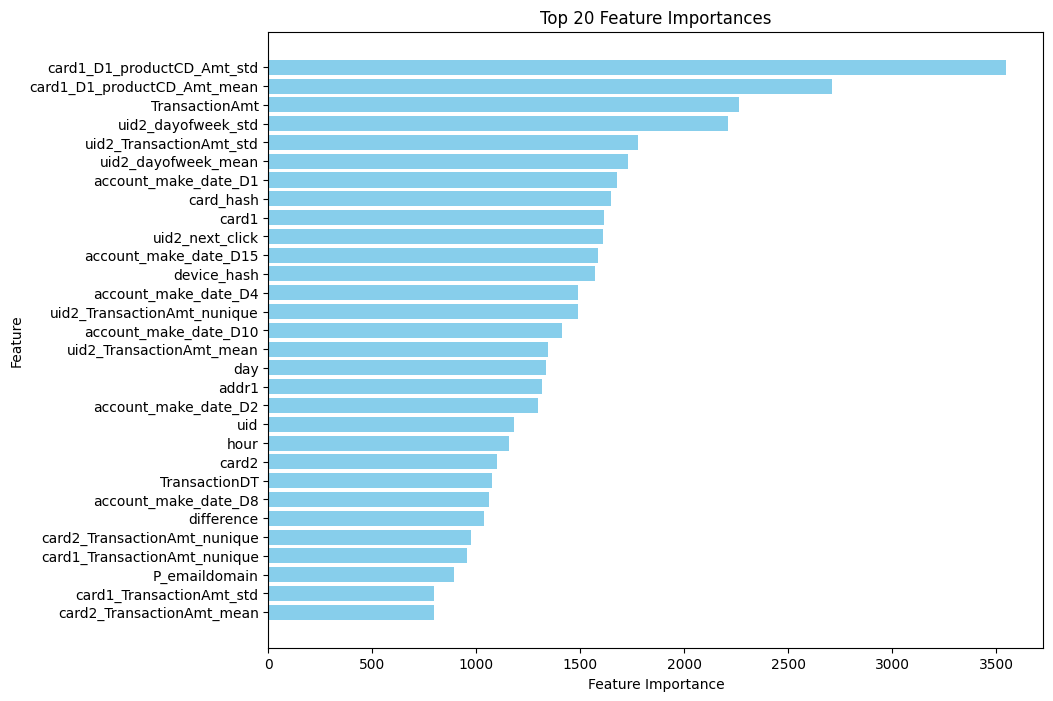

In [ ]:
import matplotlib.pyplot as plt
# 피처 중요도 추출
importance = clf.feature_importance()
feature_names = X_tr.columns

# 피처 중요도를 데이터프레임으로 변환
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
})

# 중요도 순으로 정렬하고 상위 20개 피처 선택
top_20_features = importance_df.sort_values(by='importance', ascending=False).head(30)

# 피처 중요도 시각화
plt.figure(figsize=(10, 8))
plt.barh(top_20_features['feature'], top_20_features['importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 30 Feature Importances')
plt.gca().invert_yaxis()  # 가장 중요한 피처가 위에 오도록 y축을 반전
plt.show()

# 데이터프레임의 컬럼 출력 함수
def print_columns(df):
    print("Columns in the DataFrame:")
    print(", ".join(df.columns))

#### M컬럼 추가

[LightGBM] [Info] Number of positive: 15497, number of negative: 427408
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.417310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21875
[LightGBM] [Info] Number of data points in the train set: 442905, number of used features: 129
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.034989 -> initscore=-3.317093
[LightGBM] [Info] Start training from score -3.317093
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.955376	valid_1's auc: 0.940852
[200]	training's auc: 0.973387	valid_1's auc: 0.952946
[300]	training's auc: 0.982633	valid_1's auc: 0.959782
[400]	training's auc: 0.988606	valid_1's auc: 0.964034
[500]	training's auc: 0.992501	valid_1's auc: 0.966562
[600]	training's auc: 0.995126	valid_1's auc: 0.968419
[700]	training's auc: 0.996776	valid_1's auc: 0.969863
[800]	training's auc: 0.997799	valid_1's auc: 0.971265


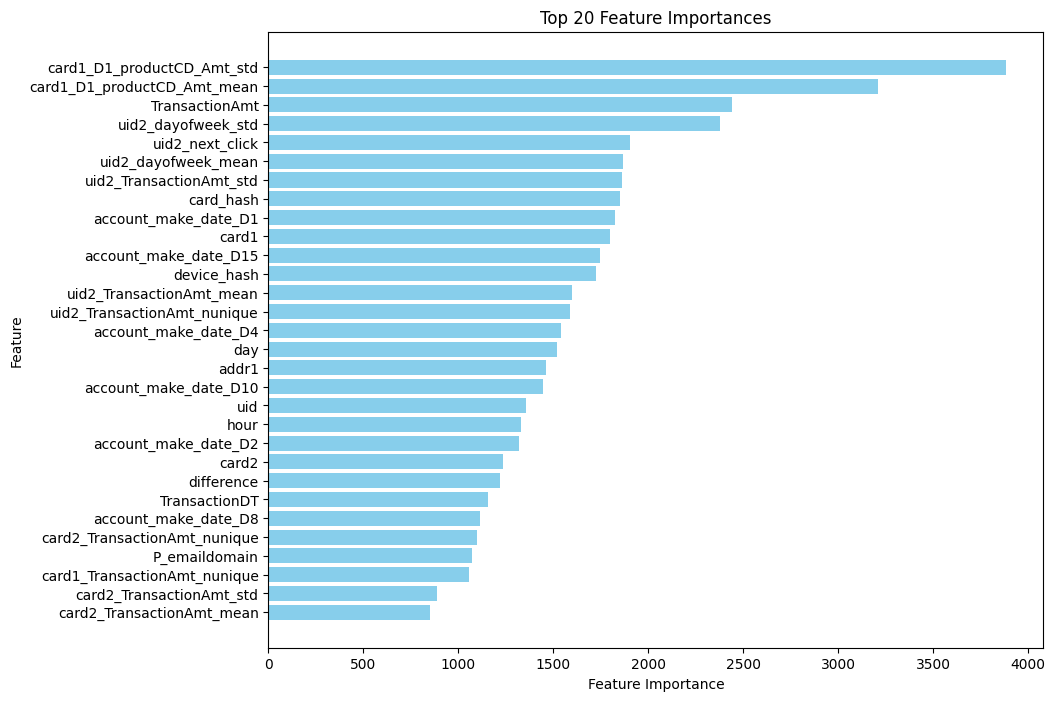

In [36]:
# Private : 0.8871
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import lightgbm as lgb

# Convert DateTime columns to numerical format
def convert_datetime_columns(df):
    for col in df.columns:
        if pd.api.types.is_datetime64_any_dtype(df[col]):
            df[col] = df[col].astype('int64') // 10**9  # Convert to seconds since epoch
    return df

# 원하는 피처 선택
selected_features = [
    'TransactionDT', 'TransactionAmt', 'card1', 'card2', 'card3', 'card5',
    'addr1', 'addr2', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9',
    'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6',
    'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'ProductCD',
    'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'dist1', 'id_34',
    'V314', 'V310', 'V127', 'V78', 'V62', 'card_hash', 'device_hash',
    'difference','V307_diff','uid', 'uid2',
    'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9',
    'C1_TransactionAmt_mean', 'C1_TransactionAmt_sum',
    'C2_TransactionAmt_mean', 'C2_TransactionAmt_sum',
    'C3_TransactionAmt_mean', 'C3_TransactionAmt_sum',
    'C4_TransactionAmt_mean', 'C4_TransactionAmt_sum',
    'C5_TransactionAmt_mean', 'C5_TransactionAmt_sum',
    'C6_TransactionAmt_mean', 'C6_TransactionAmt_sum',
    'C7_TransactionAmt_mean', 'C7_TransactionAmt_sum',
    'C8_TransactionAmt_mean', 'C8_TransactionAmt_sum',
    'C9_TransactionAmt_mean', 'C9_TransactionAmt_sum',
    'C10_TransactionAmt_mean', 'C10_TransactionAmt_sum',
    'C11_TransactionAmt_mean', 'C11_TransactionAmt_sum',
    'C12_TransactionAmt_mean', 'C12_TransactionAmt_sum',
    'C13_TransactionAmt_mean', 'C13_TransactionAmt_sum',
    'C14_TransactionAmt_mean', 'C14_TransactionAmt_sum',
    "card1_TransactionAmt_mean","card1_TransactionAmt_std","card1_TransactionAmt_nunique",
    "card2_TransactionAmt_mean","card2_TransactionAmt_std","card2_TransactionAmt_nunique",
    "card3_TransactionAmt_mean","card3_TransactionAmt_std","card3_TransactionAmt_nunique",
    "card5_TransactionAmt_mean","card5_TransactionAmt_std","card5_TransactionAmt_nunique",
    "uid_TransactionAmt_mean","uid_TransactionAmt_std","uid_TransactionAmt_nunique",
    "uid2_TransactionAmt_mean","uid2_TransactionAmt_std","uid2_TransactionAmt_nunique",
    "bank_type","address_match","account_make_date_D1","account_make_date_D2","account_make_date_D4",
    "account_make_date_D8","account_make_date_D10","account_make_date_D15",
    "date","year","month","day","dayofweek","hour", "uid2_next_click",
    "card1_D1_productCD_Amt_mean","card1_D1_productCD_Amt_std","uid2_dayofweek_mean",
    "uid2_dayofweek_std"
]

# Assuming that train and test have all required features including 'isFraud' for train
X = train[selected_features]
y = train['isFraud']
X_test = test[selected_features]

# DateTime 컬럼 변환
X = convert_datetime_columns(X)
X_test = convert_datetime_columns(X_test)

# train, valid split
X_tr, X_v, y_tr, y_v = train_test_split(X, y, test_size=0.25, random_state=2024, stratify=y)

# 데이터 셋 생성
train_data = lgb.Dataset(X_tr, label=y_tr)
valid_data = lgb.Dataset(X_v, label=y_v)

params = {
    'objective': 'binary',
    'metric': 'auc'
}

# 모델 학습
callbacks = [lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(period=100)]
clf = lgb.train(params, train_data, num_boost_round=10000, valid_sets=[train_data, valid_data], callbacks=callbacks)

# test_encoded 데이터프레임의 DateTime64 타입 열 변환
test_encoded = convert_datetime_columns(test_encoded)

# 예측 수행
preds = clf.predict(X_test)

# 결과 저장
result = pd.read_csv("sample_submission.csv")
result['isFraud'] = preds
result.to_csv('result.csv', index=False)

import matplotlib.pyplot as plt
# 피처 중요도 추출
importance = clf.feature_importance()
feature_names = X_tr.columns

# 피처 중요도를 데이터프레임으로 변환
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
})

# 중요도 순으로 정렬하고 상위 20개 피처 선택
top_20_features = importance_df.sort_values(by='importance', ascending=False).head(30)

# 피처 중요도 시각화
plt.figure(figsize=(10, 8))
plt.barh(top_20_features['feature'], top_20_features['importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis()  # 가장 중요한 피처가 위에 오도록 y축을 반전
plt.show()

In [24]:
train.head()

c:\Users\USER\Desktop\광인사\1_Project\.venv\Lib\site-packages\pandas\io\formats\format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,timeblock,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V307,ProductCD,M1,M2,M3,M4,M5,M6,M7,M8,M9,card4,card6,P_emaildomain,R_emaildomain,dist1,id_30,id_31,id_32,id_33,id_34,DeviceType,DeviceInfo,V314,V310,V127,V78,V62,isFraud,uid,uid2,card1_TransactionAmt_mean,card1_TransactionAmt_std,card1_TransactionAmt_nunique,card2_TransactionAmt_mean,card2_TransactionAmt_std,card2_TransactionAmt_nunique,card3_TransactionAmt_mean,card3_TransactionAmt_std,card3_TransactionAmt_nunique,card5_TransactionAmt_mean,card5_TransactionAmt_std,card5_TransactionAmt_nunique,uid_TransactionAmt_mean,uid_TransactionAmt_std,uid_TransactionAmt_nunique,uid2_TransactionAmt_mean,uid2_TransactionAmt_std,uid2_TransactionAmt_nunique,bank_type,address_match,account_make_date_D1,account_make_date_D2,account_make_date_D4,account_make_date_D8,account_make_date_D10,account_make_date_D15,date,year,month,day,dayofweek,hour,card_hash,device_hash,V307_diff,difference,uid2_next_click,card1_D1_productCD_Amt_mean,card1_D1_productCD_Amt_std,uid2_dayofweek_mean,uid2_dayofweek_std
0,2017-12-01 00:00:00,86400,68.5,13926,-999.0,150.0,142.0,315.0,87.0,1,1,0,0,0,1,0,0,1,0,2,0,1,1,14.0,-999.0,13.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,13.0,13.0,-999.0,-999.0,-999.0,0.0,117.0,4,2,2,2,3,1,2,0,0,0,2,2,0,0,19.0,0,0,-999.0,0,0,0,0,0.0,0.0,117.0,1.0,1.0,0,3658,10322,316.5000,351.5000,33,143.750,246.375,2206,147.625,255.375,21143,185.250,322.250,123,258.0000,210.7500,5,193.0000,176.12500,2,309,1.000000,20171117,20200826,20200826,20200826,20171118,20171201,0,2017,12,1,4,0,8296,2763,-117.0,-185.5,-6286225.0,68.500,NaN,5.000000,1.414062
1,2017-12-01 00:00:01,86401,29.0,2755,404.0,150.0,102.0,325.0,87.0,1,1,0,0,0,1,0,0,0,0,1,0,1,1,0.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,-999.0,0.0,0.0,4,0,0,0,1,2,2,0,0,0,3,2,17,0,-999.0,0,0,-999.0,0,0,0,0,0.0,0.0,0.0,1.0,1.0,0,8497,24212,213.0000,391.5000,335,227.125,373.750,888,147.625,255.375,21143,212.750,396.500,6804,213.6250,392.7500,334,240.0000,503.75000,53,44082,0.992188,20171201,20200826,20171201,20200826,20171201,20171201,0,2017,12,1,4,0,8152,2763,0.0,-29.0,-413142.0,29.000,NaN,3.000000,1.776367
2,2017-12-01 00:01:09,86469,59.0,4663,490.0,150.0,166.0,330.0,87.0,1,1,0,0,0,1,0,0,1,0,1,0,1,1,0.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,315.0,-999.0,-999.0,-999.0,315.0,0.0,4,2,2,2,1,1,1,1,1,1,4,3,36,0,287.0,0,0,-999.0,0,0,0,0,0.0,0.0,0.0,1.0,1.0,0,10070,28509,104.8750,130.3750,284,136.125,228.625,2763,147.625,255.375,21143,98.750,141.000,3382,104.8125,130.3750,284,65.6875,55.15625,23,101292,0.999023,20171201,20200826,20171201,20200826,20171201,20170120,0,2017,12,1,4,0,8694,2763,1758.0,1699.0,-864538.0,100.625,77.000,3.244141,1.569336
3,2017-12-01 00:01:39,86499,50.0,18132,567.0,150.0,117.0,476.0,87.0,2,5,0,0,0,4,0,0,1,0,1,0,25,1,112.0,112.0,0.0,94.0,0.0,-999.0,-999.0,-999.0,-999.0,84.0,-999.0,-999.0,-999.0,-999.0,111.0,1758.0,4,0,0,0,1,2,1,0,0,0,3,3,54,0,-999.0,0,0,-999.0,0,0,0,0,0.0,354.0,1758.0,1.0,1.0,0,7494,21088,120.9375,196.5000,580,133.625,226.750,774,147.625,255.375,21143,124.375,191.875,1776,120.9375,196.7500,578,113.0625,211.75000,109,47059,0.997559,20170811,20170811,20170829,20200826,20170908,20170812,0,2017,12,1,4,0,7408,2763,-1758.0,-1808.0,-8498.0,67.000,41.125,3.013672,1.973633
4,2017-12-01 00:01:46,86506,50.0,4497,514.0,150.0,102.0,420.0,87.0,1,1,0,0,0,1,0,1,0,1,1,0,1,1,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,1,0,0,0,0,0,0,0,0,0,3,2,17,0,-999.0,8,124,32.0,165,4,2,955,0.0,0.0,0.0,-999.0,-999.0,0,9944,28156,99.8125,69.8125,18,223.750,458.000,2311,147.625,255.375,21143,212.750,396.500,6804,99.8125,69.8125,18,50.0000,NaN,1,44082,0.992188,20171201,20200826,20200826,20200826,20200826,20200826,0,2017,12,1,4,0,12607,7016,0.0,-50.0,NaN,50.000,NaN,4.000000,NaN
